# Double Pendulum Problem

## Euler-Lagrange equation

For a double pendulum, the Lagrangian (with generalized coordinates $\phi_1$ and $\phi_2$) is

$\begin{align}
  \mathcal{L} = T - U = \frac12 (m_1 + m_2) L_1^2 \dot\phi_1^2 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1 - \phi_2) + \frac12 m_2 L_2^2 \dot\phi_2^2 - (m_1 + m_2) g L_1 (1 - \cos\phi_1)- m_2gL_2(1 - \cos\phi_2)
\end{align}$

The Euler-Lagrange equations (after some rearranging and simplifying) are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 (m_1 + m_2) L_1 \ddot \phi_1 + m_2 L_2 \cos(\phi_1 - \phi_2) \ddot\phi_2 = -(m_1 + m_2) g \sin\phi_1 - m_2 L_2 \dot\phi_2^2\sin(\phi_1 - \phi_2)
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial\dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 m_2 L_1 \cos(\phi_1-\phi_2)\ddot \phi_1 + m_2 L_2 \ddot\phi_2 = - m_2 g \sin\phi_2 + m_2 L_1 \dot\phi_1^2\sin(\phi_1-\phi_2)
\end{align}$

Now we solve $\begin {align}
 \ddot\phi_1 \; and \; \ddot\phi_2
 \end{align}$
in terms of other variables:

$\begin{align}
 &\ddot\phi_1 = \frac{1}{L_1\big(m_1 + m_2 \sin(\phi_1 - \phi_2)^2\big)} \Big[-(m_1 + m_2) g \sin\phi_1 - m_2 L_2 \dot\phi_2^2 \sin(\phi_1-\phi_2) + m_2 \cos(\phi_1-\phi_2) \big(g\sin\phi_2 - L_1\dot\phi_1^2\sin(\phi_1-\phi_2)\big)\Big] \\
 &\ddot\phi_2 = \frac{1}{L_2 \big(m_1 + m_2 \sin(\phi_1 - \phi_2)^2\big)} \Big[(m_1+m_2) \big(g \sin\phi_1 \cos(\phi_1-\phi_2) - g \sin\phi_2 + L_1 \dot\phi_1^2 \sin(\phi_1-\phi_2)\big) + m_2 L_2 \dot\phi_2^2 \sin(\phi_1-\phi_2) \cos(\phi_1-\phi_2) \Big]\\
\end{align}$

These equations are implemented in the method dy_dt in the DoublePendulum class.

## Things to Import

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

## Double Pendulum Class

In [2]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and Lagrange's 
    equations for a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    m1 : float
        mass of first pendulum bob
    m2 : float
        mass of second pendulum bob
    g : float
        gravitational constant

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0, abserr, relerr)
        Solve the ODE using solve_ivp given initial conditions phi1_0, phi1_dot_0, 
        phi2_0, and phi2_dot_0 and a range of t values, t_pts. It solves 
        at a given absolute error, abserr, and relative error, relerr.
    
    """
    def __init__(self, L1=1., L2=1., mass1=1., mass2=2., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.m1 = mass1
        self.m2 = mass2
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dphi1_dot/dt dphi2/dt dphi2_dot/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi1 and y[1] = phi1_dot
            y[2] = phi2 and y[3] = phi2_dot
            
        Returns
        -------
        
        """
        
        C = np.cos(y[0]-y[2])
        S = np.sin(y[0]-y[2])
        
        # The denominators that show up in Lagrange's equations
        denom_1 = self.L1 * (self.m1 + self.m2 * S**2)
        denom_2 = self.L2 * (self.m1 + self.m2 * S**2)
        
        phi1_dot = y[1]
        phi2_dot = y[3]
        
        # Lagrange's equations
        phi1_dot_dot = (-(self.m1 + self.m2) * self.g * np.sin(y[0]) \
                        - self.m2 * self.L2 * y[3]**2 * S \
                        + C * self.m2 * (self.g * np.sin(y[2]) - self.L1 * y[1]**2 * S)) \
                        / denom_1
        phi2_dot_dot = ((self.m1 + self.m2) * (self.g * np.sin(y[0]) * C \
                        - self.g * np.sin(y[2]) + self.L1 * y[1]**2 * S) \
                        + self.m2 * self.L2 * y[3]**2 * S * C) \
                        / denom_2
        
        return phi1_dot, phi1_dot_dot, phi2_dot, phi2_dot_dot
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, 
                  phi2_0, phi2_dot_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot

### Plotting Function

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Simple Double Pendulum Plot

In [5]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')

# Labels for the first angle
phi1_vs_time_labels = (r'$t$', r'$\phi_1(t)$')
phi1_dot_vs_time_labels = (r'$t$', r'$\dot\phi_1(t)$')
state_space_1_labels = (r'$\phi_1$', r'$\dot\phi_1$')

# Labels for the second angle
phi2_vs_time_labels = (r'$t$', r'$\phi_2(t)$')
phi2_dot_vs_time_labels = (r'$t$', r'$\dot\phi_2(t)$')
state_space_2_labels = (r'$\phi_2$', r'$\dot\phi_2$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 500.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Pendulum parameters
L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate a pendulum 
p1 = DoublePendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

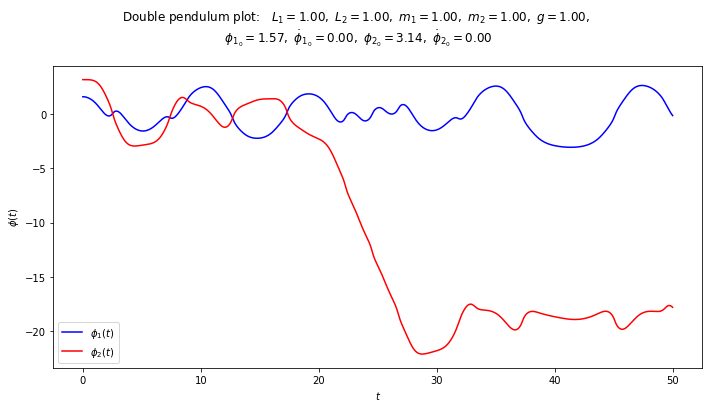

In [6]:
# Initial conditions for the plot
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.
phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0,
                                             phi2_0, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum plot:  ' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $g = {g:.2f},$' + \
                '\n' + \
                rf' $\phi_{{1_0}} = {phi1_0:.2f},$' + \
                rf' $\dot\phi_{{1_0}} = {phi1_dot_0:.2f},$' + \
                rf' $\phi_{{2_0}} = {phi2_0:.2f},$' + \
                rf' $\dot\phi_{{2_0}} = {phi2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot the angle of both pendulums on the same plot  
ax_a = fig.add_subplot(1,1,1)                  

# Get indices to only plot from t=0 to t=50
start, stop = start_stop_indices(t_pts, t_start, 50.)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\phi_1(t)$', 
            title=None, 
            ax=ax_a)                                                   
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=r'$\phi_2(t)$', 
            title=None, 
            ax=ax_a)    


fig.tight_layout()
fig.savefig('DoublePendulum', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'

## Looking for chaos: sensitivity to initial conditions

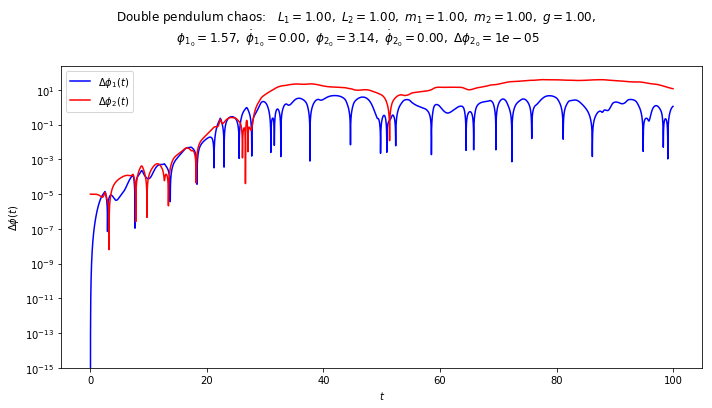

In [7]:
# Labels for individual plot axes
Delta_phi_vs_time_labels = (r'$t$', r'$\Delta\phi(t)$')
Delta_phi_1_vs_time_labels = (r'$t$', r'$\Delta\phi_1(t)$')
Delta_phi_2_vs_time_labels = (r'$t$', r'$\Delta\phi_2(t)$')

# Initial conditions for the first pendulum
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.
phi1_1, phi1_dot_1, phi2_1, phi2_dot_1 = p1.solve_ode(t_pts, phi1_0, phi1_dot_0,
                                             phi2_0, phi2_dot_0)

# Change initial conditions slightly to show chaos
Delta_phi2_0 = 0.00001
phi2_0_2 = np.pi - Delta_phi2_0
phi1_2, phi1_dot_2, phi2_2, phi2_dot_2 = p1.solve_ode(t_pts, phi1_0, phi1_dot_0,
                                             phi2_0_2, phi2_dot_0)

Delta_phi_1 = np.fabs(phi1_1 - phi1_2)
Delta_phi_2 = np.fabs(phi2_1 - phi2_2)

# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum chaos:  ' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $g = {g:.2f},$' + \
                '\n' + \
                rf' $\phi_{{1_0}} = {phi1_0:.2f},$' + \
                rf' $\dot\phi_{{1_0}} = {phi1_dot_0:.2f},$' + \
                rf' $\phi_{{2_0}} = {phi2_0:.2f},$' + \
                rf' $\dot\phi_{{2_0}} = {phi2_dot_0:.2f},$' + \
                rf' $\Delta\phi_{{2_0}} = {Delta_phi2_0}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot Delta_phi for both angles vs. time on the same plot  
ax_a = fig.add_subplot(1,1,1)                  

# Get indices to only plot from t=0 to t=100
start, stop = start_stop_indices(t_pts, t_start, 100.)    
plot_y_vs_x(t_pts[start : stop], Delta_phi_1[start : stop], 
            axis_labels=Delta_phi_vs_time_labels, 
            color='blue',
            label=r'$\Delta\phi_1(t)$', 
            title=None,
            semilogy=True,
            ax=ax_a)                                                   
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            axis_labels=Delta_phi_vs_time_labels, 
            color='red',
            label=r'$\Delta\phi_2(t)$', 
            title=None,
            semilogy=True,
            ax=ax_a)    

fig.tight_layout()
fig.savefig('DoublePendulum_chaos', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'